## HR Analytics - Job Change of Data Scentists

## 1.0 Prepration 

In [122]:
# Dependencies
import pandas as pd
import numpy as np
import psycopg2
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from db_connection import postgreSQLConnection

In [123]:
#Machine Learning Dependencies
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel


In [124]:
# read the tables
hrds_train_features_df      = pd.read_sql("select * from \"hrds_train_features\"", postgreSQLConnection);
hrds_train_labels_df      = pd.read_sql("select * from \"hrds_train_labels\"", postgreSQLConnection);
hrds_test_df = pd.read_sql("select * from \"hrds_test_features\"", postgreSQLConnection);

StatementError: (sqlalchemy.exc.ResourceClosedError) This Connection is closed
[SQL: select * from "hrds_train_features"]

In [ ]:
postgreSQLConnection.close()

# 2.0 Exploratory Analysis


## 2.1 Initial Check

In [ ]:
# show the top 5 features records
hrds_train_features_df.head()

In [ ]:
# Checking counts of rows and columns
hrds_train_features_df.shape

In [ ]:
# show the top 5 lables records
hrds_train_labels_df.head()

In [ ]:
# Checking features
hrds_train_features_df.columns.tolist()

In [ ]:
#Merge the dataset
hrds_train_df = hrds_train_features_df.merge(hrds_train_labels_df, on='enrollee_id', how='left')
hrds_train_df.head()

In [ ]:
#Unique counts for each column 
hrds_train_df.apply(lambda x: x.nunique())

In [ ]:
hrds_train_df.drop('enrollee_id', axis=1, inplace=True)
hrds_test_df.drop('enrollee_id', axis=1, inplace=True)


In [ ]:
sns.pairplot(hrds_train_df, diag_kind="kde")

## 2.1 Data Clean up 

In [ ]:
counts_1 = hrds_train_df["gender"].value_counts()
counts_1.head()

In [ ]:
# Null values Check  
hrds_train_df.isnull().sum()

In [ ]:
hrds_test_df.isnull().sum()

In [ ]:
#check missing value + percentage 
missing = hrds_train_df.isnull().sum().sort_values(ascending=False).reset_index()
missing.columns = ['features','missing_num']
missing['percentage'] = missing['missing_num']/hrds_train_df.shape[0]
missing

In [ ]:
hrds_train_df.dtypes

In [ ]:
# fill missing data  
hrds_train_df['experience'] = hrds_train_df['experience'].fillna('-1')
hrds_train_df['last_new_job'] = hrds_train_df['last_new_job'].fillna('-1')
hrds_train_df['enrolled_university'] = hrds_train_df['enrolled_university'].fillna('Unknown')
#hrds_train_df['gender'] = hrds_train_df['gender'].fillna('Unknown')
hrds_train_df['major_discipline'] = hrds_train_df['major_discipline'].fillna('Others')
hrds_train_df['education_level'] = hrds_train_df['education_level'].fillna('Unknown')
#hrds_train_df['company_size'] = hrds_train_df['company_size'].fillna('TBC')
#hrds_train_df['company_type'] = hrds_train_df['company_type'].fillna('TBC')
# COMPANY SIZE AND COMPANY TYPE NEEDS TO BE CODEDE USING RAMDOM METHOD TBC=TO BE CODED 
hrds_train_df.head()

In [ ]:
# fill missing data  
hrds_test_df['experience'] = hrds_test_df['experience'].fillna('-1')
hrds_test_df['last_new_job'] = hrds_test_df['last_new_job'].fillna('-1')
hrds_test_df['enrolled_university'] = hrds_test_df['enrolled_university'].fillna('Unknown')
#hrds_test_df['gender'] = hrds_test_df['gender'].fillna('Unknown')
hrds_test_df['major_discipline'] = hrds_test_df['major_discipline'].fillna('Others')
hrds_test_df['education_level'] = hrds_test_df['education_level'].fillna('Unknown')
#hrds_test_df['company_size'] = hrds_test_df['company_size'].fillna('TBC')
#hrds_test_df['company_type'] = hrds_test_df['company_type'].fillna('TBC')
# COMPANY SIZE AND COMPANY TYPE NEEDS TO BE CODEDE USING RAMDOM METHOD TBC=TO BE CODED 
hrds_test_df.head()

In [ ]:
counts_1 = hrds_train_df["gender"].value_counts()
counts_1.head()

In [ ]:
counts1 = hrds_train_df["company_size"].value_counts()
counts1.head()

In [ ]:
counts2 = hrds_train_df["company_type"].value_counts()
counts2.head()

In [ ]:
#https://stackoverflow.com/questions/64485812/how-to-generate-random-categorical-data-from-existing-ones-to-fill-missing-value
#import random
#hrds_train_df['company_type'].applymap(lambda x: x if not np.isnan(x) else np.random.choice(random.choice(list(x.dropna(axis=0)))))
def na_randomfill(series):
    na_mask = pd.isnull(series)   # boolean mask for null values
    n_null = na_mask.sum()        # number of nulls in the Series
    
    if n_null == 0:
        return series             # if there are no nulls, no need to resample
    
    # Randomly sample the non-null values from our series
    #  only sample this Series as many times as we have nulls 
    fill_values = series[~na_mask].sample(n=n_null, replace=True, random_state=0)

    # This ensures our new values will replace NaNs in the correct locations
    fill_values.index = series.index[na_mask]
    
    return series.fillna(fill_values)

In [ ]:
out = na_randomfill(hrds_train_df["company_type"])
out_1 = na_randomfill(hrds_train_df["company_size"])
out_2 = na_randomfill(hrds_train_df["gender"])
#print(out)
hrds_train_df["company_type"] = out  
hrds_train_df["company_size"] = out_1
hrds_train_df["gender"] = out_2

In [ ]:
out = na_randomfill(hrds_test_df["company_type"])
out_1 = na_randomfill(hrds_test_df["company_size"])
out_2 = na_randomfill(hrds_test_df["gender"])
#print(out)
hrds_test_df["company_type"] = out  
hrds_test_df["company_size"] = out_1
hrds_test_df["gender"] = out_2

In [ ]:
counts_2 = hrds_train_df["gender"].value_counts()
counts_2.head()

In [ ]:
missing = hrds_train_df.isnull().sum().sort_values(ascending=False).reset_index()
missing.columns = ['features','missing_num']
missing['percentage'] = missing['missing_num']/hrds_train_df.shape[0]
missing

In [ ]:
counts3 = hrds_train_df["company_size"].value_counts()
counts3.head()
#hrds_train_df.head()

In [ ]:
counts4 = hrds_train_df["company_type"].value_counts()
counts4.head()

## 2.2 Raw Data Visualization 

In [ ]:
#Education level 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

el = hrds_train_df['education_level'].value_counts().reset_index()
el.columns = [
    'education_level', 
    'percent'
]
el['percent'] /= len(hrds_train_df)

fig = px.pie(
    el, 
    names='education_level', 
    values='percent', 
    title='Education_level', 
    width=800,
    height=500 
)

fig.show()

In [ ]:
# Experience 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

ep = hrds_train_df['experience'].value_counts().reset_index()
ep.columns = [
    'experience', 
    'percent'
]
ep['percent'] /= len(hrds_train_df)

fig = px.pie(
    ep, 
    names='experience', 
    values='percent', 
    title='Work Experience in Years', 
    width=800,
    height=500 
)

fig.show()


In [ ]:
# Experience 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

ep = hrds_train_df['last_new_job'].value_counts().reset_index()
ep.columns = [
    'last_new_job', 
    'percent'
]
ep['percent'] /= len(hrds_train_df)

fig = px.pie(
    ep, 
    names='last_new_job', 
    values='percent', 
    title='Number of years between last and current job', 
    width=800,
    height=500 
)

fig.show()

In [ ]:
#Training Hrs
f, axes = plt.subplots(1,1, figsize = (16, 5))
g1 = sns.histplot(hrds_train_df["training_hours"], color="blue",ax = axes)
plt.title("Distributional of training_hours")

In [ ]:
plt.figure(figsize = (10, 6))

ax = hrds_train_df['city_development_index'].plot(kind='kde')
ax.set(ylabel="Density", xlabel="Development Index")
plt.title("Development Index") 
plt.show()

#plt.savefig("./dev_index_density.png", fontsize=15)

In [ ]:
#balance check 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

ep = hrds_train_df['target'].value_counts().reset_index()
ep.columns = [
    'target', 
    'percent'
]
ep['percent'] /= len(hrds_train_df)

fig = px.pie(
    ep, 
    names='target', 
    values='percent', 
    title='Balance check', 
    width=800,
    height=500 
)

fig.show()


# Perform encoding on categorical values

In [ ]:
hrds_test_df_copy=hrds_test_df.copy()
hrds_train_df_copy=hrds_train_df.copy()


In [ ]:
display(hrds_train_df.head())
display(hrds_test_df.head())

In [125]:
hrds_test_df=hrds_test_df_copy.copy()
hrds_train_df=hrds_train_df_copy.copy()

In [126]:

# strip the 'city_' from city
hrds_test_df['city'] = hrds_test_df['city'].map(lambda x:int(x.strip().strip('city_')))
hrds_train_df['city'] = hrds_train_df['city'].map(lambda x:int(x.strip().strip('city_')))
hrds_test_df['city'] = hrds_test_df['city'].map(lambda x:int(x))
hrds_train_df['city'] = hrds_train_df['city'].map(lambda x:int(x))

# Fitting and encoding the columns with the LabelEncoder
# Create the LabelEncoder instance
le = LabelEncoder()

# gender column
le.fit(hrds_train_df["gender"])
hrds_train_df["gender"] = le.transform(hrds_train_df["gender"])
le.fit(hrds_test_df["gender"])
hrds_test_df["gender"] = le.transform(hrds_test_df["gender"])

# city column
le.fit(hrds_train_df["city"])
hrds_train_df["city"] = le.transform(hrds_train_df["city"])
le.fit(hrds_test_df["city"])
hrds_test_df["city"] = le.transform(hrds_test_df["city"])

# Encoding relevent_experience column
le.fit(hrds_train_df["relevent_experience"])
hrds_train_df["relevent_experience"] = le.transform(hrds_train_df["relevent_experience"])
le.fit(hrds_test_df["relevent_experience"])
hrds_test_df["relevent_experience"] = le.transform(hrds_test_df["relevent_experience"])

# Encoding enrolled_university column
le.fit(hrds_train_df["enrolled_university"])
hrds_train_df["enrolled_university"] = le.transform(hrds_train_df["enrolled_university"])
le.fit(hrds_test_df["enrolled_university"])
hrds_test_df["enrolled_university"] = le.transform(hrds_test_df["enrolled_university"])

# Encoding education_level column
le.fit(hrds_train_df["education_level"])
hrds_train_df["education_level"] = le.transform(hrds_train_df["education_level"])
le.fit(hrds_test_df["education_level"])
hrds_test_df["education_level"] = le.transform(hrds_test_df["education_level"])

# Encoding major_discipline column
le.fit(hrds_train_df["major_discipline"])
hrds_train_df["major_discipline"] = le.transform(hrds_train_df["major_discipline"])
le.fit(hrds_test_df["major_discipline"])
hrds_test_df["major_discipline"] = le.transform(hrds_test_df["major_discipline"])

# Encoding experience column
le.fit(hrds_train_df["experience"])
hrds_train_df["experience"] = le.transform(hrds_train_df["experience"])
le.fit(hrds_test_df["experience"])
hrds_test_df["experience"] = le.transform(hrds_test_df["experience"])

# Encoding company_size column
le.fit(hrds_train_df["company_size"])
hrds_train_df["company_size"] = le.transform(hrds_train_df["company_size"])
le.fit(hrds_test_df["company_size"])
hrds_test_df["company_size"] = le.transform(hrds_test_df["company_size"])

# Encoding company_type column
le.fit(hrds_train_df["company_type"])
hrds_train_df["company_type"] = le.transform(hrds_train_df["company_type"])
le.fit(hrds_test_df["company_type"])
hrds_test_df["company_type"] = le.transform(hrds_test_df["company_type"])

# Encoding last_new_job column
le.fit(hrds_train_df["last_new_job"])
hrds_train_df["last_new_job"] = le.transform(hrds_train_df["last_new_job"])
le.fit(hrds_test_df["last_new_job"])
hrds_test_df["last_new_job"] = le.transform(hrds_test_df["last_new_job"])

display(hrds_train_df.head())
display(hrds_test_df.head())


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,73,0.920,1,0,3,0,6,22,2,4,1,36,1
1,27,0.776,1,1,3,0,6,7,4,5,5,47,0
2,14,0.624,1,1,0,0,6,16,5,5,6,83,0
3,81,0.789,1,1,2,0,1,21,5,5,6,52,1
4,113,0.767,1,0,3,2,6,22,4,1,4,8,0


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,25,0.827,1,0,0,0,6,20,7,5,1,21
1,66,0.920,0,0,3,0,6,16,1,5,1,98
2,11,0.624,1,1,3,1,5,21,2,5,6,15
3,6,0.827,1,0,3,2,6,3,0,5,1,39
4,66,0.920,1,0,3,0,6,22,3,5,5,72


## 3.1 Coding & Scaling

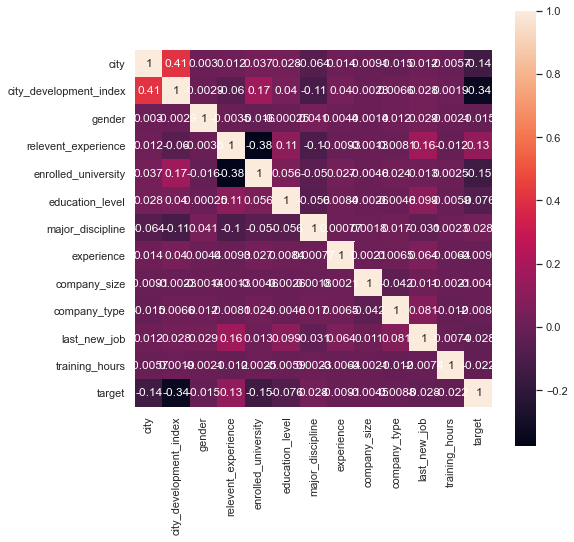

In [127]:
#initial check of correlation 
plt.figure(figsize=(8,8))
sns.heatmap((hrds_train_df).corr(), annot=True, square=True)
plt.show()


In [128]:

# Generate our categorical variable list
train_cat = hrds_train_df.dtypes[hrds_train_df.dtypes == "object"].index.tolist()


# Check the number of unique values in each column
hrds_train_df[train_cat].nunique()

#encode the company type & size


#RANDOM Selection of company type/ company size 
#unique values, random generator 

Series([], dtype: float64)

In [129]:
counts5 = hrds_train_df["gender"].value_counts()
counts5.head()

1    17303
0     1618
2      237
Name: gender, dtype: int64

In [130]:
X =hrds_train_df.drop("target" , axis =1)

y = hrds_train_df["target"]

print(X.shape,y.shape)

(19158, 12) (19158,)


# 3.0 Machine Learning 

In [131]:
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape

(14368, 12)

<AxesSubplot:xlabel='target', ylabel='count'>

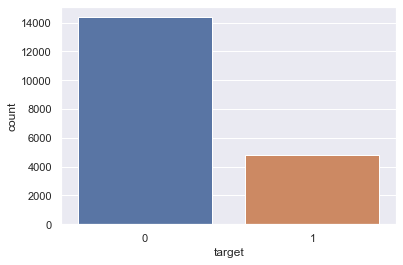

In [132]:
sns.countplot(x = "target" , data = hrds_train_df)

In [133]:
hrds_train_df["target"].value_counts()

# Number of employees looking for new job is lower than those who remain.


0    14381
1     4777
Name: target, dtype: int64

In [134]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({0: 10785, 1: 10785})

## 3.2 Random Forrest 

In [135]:
# Function to return the confusion metrics and accuracy score
def result_metrics(y_test, predicted, model):
    '''
    y_test is the test data
    predicted is the prediction
    model is the model used for the prediction
    '''
    # Calculating the confusion matrix.
    cm = confusion_matrix(y_test, predicted)

    # Create a DataFrame from the confusion matrix.
    cm_df = pd.DataFrame(
        cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

    cm_df['model']=model

    # Calculating the accuracy score.
    acc_score = accuracy_score(y_test, predicted)

    # Displaying results
    print("------------------------------------")
    print(f"Results for {model}")
    print("------------------------------------")
    print("Confusion Matrix:")
    display(cm_df)
    print("\n")
    accuracy_df = pd.DataFrame(classification_report(y_test, predicted,output_dict=True))
    accuracy_df['model'] = model
    print(f"Accuracy Score : {acc_score}\n")
    print("Classification Report")
    display(accuracy_df)    
    return cm_df,accuracy_df



In [136]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

In [137]:
# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

In [138]:
# save the model to disk
filename = 'rf_model.pckl'
pickle.dump(rf_model, open('Resources/rf_model.pckl', 'wb'))

In [139]:
# Making predictions using the testing data.
predicted = rf_model.predict(X_test)

In [140]:
# accuracy report
rf_cm, rf_acc = result_metrics(y_test, predicted, 'RandomForest')

------------------------------------
Results for RandomForest
------------------------------------
Confusion Matrix:


,Predicted 0,Predicted 1,model
Actual 0,3245,351,RandomForest
Actual 1,799,395,RandomForest




Accuracy Score : 0.7599164926931107

Classification Report


,0,1,accuracy,macro avg,weighted avg,model
precision,0.802423,0.529491,0.759916,0.665957,0.734390,RandomForest
recall,0.902392,0.330821,0.759916,0.616606,0.759916,RandomForest
f1-score,0.849476,0.407216,0.759916,0.628346,0.739235,RandomForest
support,3596.000000,1194.000000,0.759916,4790.000000,4790.000000,RandomForest


In [141]:
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'predicted: {predicted.shape}')


X_test: (4790, 12)
y_test: (4790,)
X_train: (14368, 12)
y_train: (14368,)
predicted: (4790,)


## 3.3 Logistic Regression 

In [142]:
X_resampled.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,33,0.762,1,1,3,0,6,12,1,1,2,192
1,72,0.804,1,0,3,0,6,21,4,5,2,11
2,112,0.920,1,1,0,0,6,5,4,5,1,52
3,73,0.920,1,0,3,0,6,5,1,5,5,140
4,10,0.910,1,0,3,5,5,16,6,4,4,214


In [143]:
# Train the Logistic Regression model using the resampled data
from sklearn.metrics import classification_report
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

C:\Users\MermaidZhang\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(random_state=1)

In [144]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)

In [145]:
lr_cm, lr_acc = result_metrics(y_test, y_pred, 'LogisticRegression')

------------------------------------
Results for LogisticRegression
------------------------------------
Confusion Matrix:


,Predicted 0,Predicted 1,model
Actual 0,2376,1220,LogisticRegression
Actual 1,460,734,LogisticRegression




Accuracy Score : 0.6492693110647182

Classification Report


,0,1,accuracy,macro avg,weighted avg,model
precision,0.837800,0.375640,0.649269,0.606720,0.722597,LogisticRegression
recall,0.660734,0.614740,0.649269,0.637737,0.649269,LogisticRegression
f1-score,0.738806,0.466328,0.649269,0.602567,0.670886,LogisticRegression
support,3596.000000,1194.000000,0.649269,4790.000000,4790.000000,LogisticRegression


## 3.5 KNN

In [146]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.cross_validation import cross_val_score
# instantiate learning model (k = 3)
knn_model = KNeighborsClassifier(n_neighbors=3)
# fit the model
knn_model.fit(X_train, y_train)
# Accuracy
knn_model.score(X_train, y_train)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(knn_model.predict(X_test))
probs = pd.DataFrame(knn_model.predict_proba(X_test))



In [147]:
knn_cm, knn_acc = result_metrics(y_test, predicted, 'KNN')

------------------------------------
Results for KNN
------------------------------------
Confusion Matrix:


,Predicted 0,Predicted 1,model
Actual 0,3086,510,KNN
Actual 1,861,333,KNN




Accuracy Score : 0.7137787056367432

Classification Report


,0,1,accuracy,macro avg,weighted avg,model
precision,0.781860,0.395018,0.713779,0.588439,0.685432,KNN
recall,0.858176,0.278894,0.713779,0.568535,0.713779,KNN
f1-score,0.818242,0.326951,0.713779,0.572597,0.695778,KNN
support,3596.000000,1194.000000,0.713779,4790.000000,4790.000000,KNN


## 3.6 Compare models 


In [148]:
accuracy_df = pd.concat([rf_acc,lr_acc,knn_acc],axis=0)
confusion_df = pd.concat([rf_cm,lr_cm,knn_cm])
print("Scores across all models")
display(accuracy_df.sort_values(by='accuracy',ascending=False))
print("\nConfusion metrics across all models")
display(confusion_df)

Scores across all models


,0,1,accuracy,macro avg,weighted avg,model
precision,0.802423,0.529491,0.759916,0.665957,0.734390,RandomForest
recall,0.902392,0.330821,0.759916,0.616606,0.759916,RandomForest
f1-score,0.849476,0.407216,0.759916,0.628346,0.739235,RandomForest
support,3596.000000,1194.000000,0.759916,4790.000000,4790.000000,RandomForest
precision,0.781860,0.395018,0.713779,0.588439,0.685432,KNN
recall,0.858176,0.278894,0.713779,0.568535,0.713779,KNN
f1-score,0.818242,0.326951,0.713779,0.572597,0.695778,KNN
support,3596.000000,1194.000000,0.713779,4790.000000,4790.000000,KNN
precision,0.837800,0.375640,0.649269,0.606720,0.722597,LogisticRegression
recall,0.660734,0.614740,0.649269,0.637737,0.649269,LogisticRegression



Confusion metrics across all models


,Predicted 0,Predicted 1,model
Actual 0,3245,351,RandomForest
Actual 1,799,395,RandomForest
Actual 0,2376,1220,LogisticRegression
Actual 1,460,734,LogisticRegression
Actual 0,3086,510,KNN
Actual 1,861,333,KNN


In [149]:
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_
# We can sort the features by their importance.
sorted(zip(map(lambda x: round(x, 4),importances), X.columns), reverse=True)
#insert a bar chart here 

[(0.2367, 'training_hours'),
 (0.1621, 'city_development_index'),
 (0.1366, 'experience'),
 (0.1045, 'city'),
 (0.1014, 'company_size'),
 (0.0721, 'last_new_job'),
 (0.047, 'company_type'),
 (0.035, 'enrolled_university'),
 (0.0313, 'education_level'),
 (0.0294, 'major_discipline'),
 (0.0235, 'relevent_experience'),
 (0.0205, 'gender')]

# Random Forest is chosen as our final model
### We are going to bin the training_hours,city_development_index, and experience
### and re-model using the Random Forest
### bining the data will allow us to provide also a better analysis
### as to what is needed to select our future candidates for training

# Add training_hours and city_index bins

In [150]:
data= hrds_train_df['training_hours'].value_counts()
data

28     329
12     292
18     291
22     282
50     279
      ... 
266      6
272      5
234      5
286      5
238      4
Name: training_hours, Length: 241, dtype: int64

241


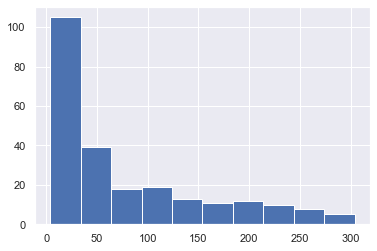

In [151]:
# potential for bining. too many feature values
data= hrds_train_df['training_hours'].value_counts()
bins = np.arange(min(data),max(data)+1, 30)
print(data.count())
plt.hist(data, bins)

plt.show()

[Reference](https://courses.bootcampspot.com/courses/310/pages/19-dot-3-3-practice-encoding-categorical-variables?module_item_id=105570)<br>

This tells us the most common unique values have more than 100 instances within the data set

<AxesSubplot:ylabel='Density'>

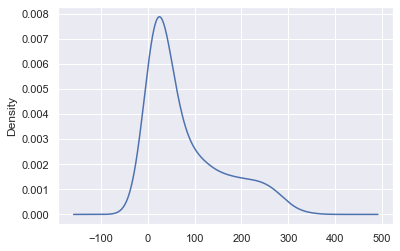

In [152]:
# Visualize the value counts
data.plot.density()

In [153]:
bins

array([  4,  34,  64,  94, 124, 154, 184, 214, 244, 274, 304])

In [154]:
# We bin as follows
#0 to 100
#101 to 250
#251 and up
bins = [-np.inf, 101, 251, np.inf]
hrds_train_df['training_buckets'] = \
    pd.cut(hrds_train_df['training_hours'], bins,labels=['100 or less','101 to 250','251 and up'])
hrds_test_df['training_buckets'] = \
    pd.cut(hrds_test_df['training_hours'], bins,labels=['100 or less','101 to 250','251 and up'])

In [155]:
hrds_train_df['training_buckets'].value_counts().sort_values()

251 and up       412
101 to 250      3418
100 or less    15328
Name: training_buckets, dtype: int64

### Add city index bucketing

In [156]:
data_1= hrds_train_df['city_development_index']
data_1.sort_values()

13549    0.448
7725     0.448
16556    0.448
1525     0.448
17702    0.448
         ...  
3772     0.949
3905     0.949
7397     0.949
9347     0.949
1739     0.949
Name: city_development_index, Length: 19158, dtype: float64

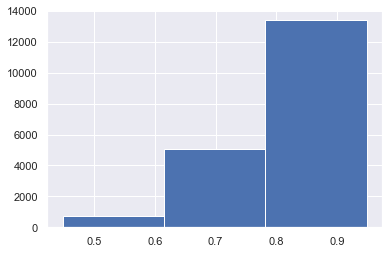

In [157]:
# potential for bining. too many feature values
plt.hist(data_1.sort_values(), bins=3)
plt.show()

In [158]:
x_ticks = [float(f'{0.4+x/100:.2}') for x in range(1,60,2)]

<AxesSubplot:ylabel='Density'>

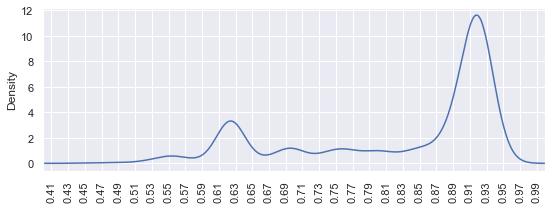

In [159]:
# Visualize the value counts
data_1.sort_values().plot.density(figsize=(9,3),xlim=(0.4,1),grid=True,xticks=x_ticks,rot=90)

In [160]:
def city_index_bin(x):
    if x < 0.63:
        return 'low density'
    elif (x >= 0.63) and (x < 0.91):
        return 'medim density'
    else:
        return 'high density'

In [161]:
''' 
We bin as follows
< 0.63: 'low density'
>= 0.63 and < 0.91:'medium density'
>= 0.91: return 'high density'
'''
hrds_train_df['city_index_buckets'] = hrds_train_df['city_development_index'].map(city_index_bin)
hrds_test_df['city_index_buckets'] = hrds_test_df['city_development_index'].map(city_index_bin)

In [162]:
hrds_train_df.city_index_buckets.value_counts()

high density     9561
medim density    6167
low density      3430
Name: city_index_buckets, dtype: int64

In [163]:
data_2 = hrds_train_df.experience
data_2.value_counts().sort_values()

0       65
13     148
10     280
11     304
9      342
5      399
4      494
8      508
21     522
1      549
6      586
3      664
7      686
19     802
20     980
2      985
18    1028
12    1127
17    1216
14    1354
15    1403
16    1430
22    3286
Name: experience, dtype: int64

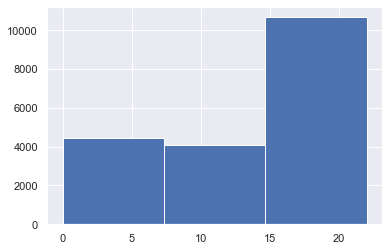

In [164]:
# potential for bining. too many feature values
plt.hist(data_2.sort_values(), bins=3)
plt.show()

<AxesSubplot:ylabel='Density'>

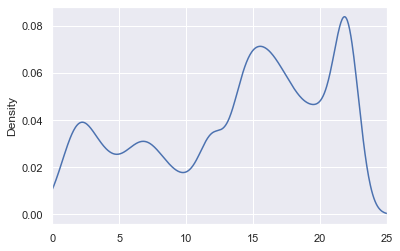

In [165]:
# Visualize the value counts
data_2.sort_values().plot.density(xlim=(0,25))

In [166]:
def train_experience_bin(x):
    if x  <=10:
        return 'junior'
    elif x >10 and x<19:
        return 'associate'
    else:
        return 'senior'

### The `experience` field in Test data contains string values 

In [167]:
def test_experience_bin(x):
    if x in ['<1','1','2','3','4','5','6','7','8','9','10']:
        return 'junior'
    elif x in ['11','12','13','14','15','16','17','18']:
        return 'associate'
    else:
        return 'senior'

In [168]:
hrds_train_df['experience_buckets'] = hrds_train_df['experience'].map(train_experience_bin)
hrds_test_df['experience_buckets'] = hrds_test_df['experience'].map(test_experience_bin)

In [169]:
hrds_train_df.experience_buckets.value_counts()

associate    8010
senior       5590
junior       5558
Name: experience_buckets, dtype: int64

In [170]:
hrds_test_df.experience_buckets.value_counts()

senior    2129
Name: experience_buckets, dtype: int64

In [171]:
train_columns = ['city', 'gender', 'relevent_experience', \
       'enrolled_university', 'education_level', 'major_discipline', \
        'company_size', 'company_type', 'last_new_job', \
       'training_buckets', 'city_index_buckets', \
       'experience_buckets','target']

In [172]:
test_columns = ['city', 'gender', 'relevent_experience', \
       'enrolled_university', 'education_level', 'major_discipline', \
        'company_size', 'company_type', 'last_new_job', \
       'training_buckets', 'city_index_buckets', \
       'experience_buckets']

In [173]:
hrds_train_df = hrds_train_df[train_columns]
hrds_test_df = hrds_test_df[test_columns]

In [174]:
hrds_test_df.columns

Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'company_size', 'company_type',
       'last_new_job', 'training_buckets', 'city_index_buckets',
       'experience_buckets'],
      dtype='object')

In [175]:
hrds_train_df.columns

Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'company_size', 'company_type',
       'last_new_job', 'training_buckets', 'city_index_buckets',
       'experience_buckets', 'target'],
      dtype='object')

# encode the new bins

In [176]:
# Encode the binned features for training
le.fit(hrds_train_df["training_buckets"])
hrds_train_df["training_encoded"] = le.transform(hrds_train_df["training_buckets"])
le.fit(hrds_train_df["city_index_buckets"])
hrds_train_df["city_index_encoded"] = le.transform(hrds_train_df["city_index_buckets"])
le.fit(hrds_train_df["experience_buckets"])
hrds_train_df["experience_encoded"] = le.transform(hrds_train_df["experience_buckets"])
# Encode the binned features for test
le.fit(hrds_test_df["training_buckets"])
hrds_test_df["training_encoded"] = le.transform(hrds_test_df["training_buckets"])
le.fit(hrds_test_df["city_index_buckets"])
hrds_test_df["city_index_encoded"] = le.transform(hrds_test_df["city_index_buckets"])
le.fit(hrds_test_df["experience_buckets"])
hrds_test_df["experience_encoded"] = le.transform(hrds_test_df["experience_buckets"])

In [177]:
# save categorical values of bins 
binned_features = ['training_buckets','city_index_buckets','experience_buckets','training_encoded','city_index_encoded','experience_encoded']
binned_features_test_df=hrds_test_df[binned_features]
binned_features_train_df=hrds_test_df[binned_features]

In [178]:
# drop the categorical values
hrds_test_df = hrds_test_df.drop(['training_buckets','city_index_buckets','experience_buckets'],axis=1)
hrds_train_df = hrds_train_df.drop(['training_buckets','city_index_buckets','experience_buckets'],axis=1)

# Model with Random forest

In [179]:
X =hrds_train_df.drop("target" , axis =1)
y = hrds_train_df["target"]
print(X.shape,y.shape)

(19158, 12) (19158,)


In [180]:
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)

In [181]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)
# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

In [182]:
# Making predictions using the testing data.
predicted = rf_model.predict(X_test)

In [183]:
# accuracy report
rf_cm, rf_acc = result_metrics(y_test, predicted, 'RandomForest')

------------------------------------
Results for RandomForest
------------------------------------
Confusion Matrix:


,Predicted 0,Predicted 1,model
Actual 0,3208,388,RandomForest
Actual 1,800,394,RandomForest




Accuracy Score : 0.7519832985386221

Classification Report


,0,1,accuracy,macro avg,weighted avg,model
precision,0.800399,0.503836,0.751983,0.652118,0.726475,RandomForest
recall,0.892102,0.329983,0.751983,0.611043,0.751983,RandomForest
f1-score,0.843766,0.398785,0.751983,0.621276,0.732846,RandomForest
support,3596.000000,1194.000000,0.751983,4790.000000,4790.000000,RandomForest


In [184]:
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_
# We can sort the features by their importance.
sorted(zip(map(lambda x: round(x, 4),importances), X.columns), reverse=True)

[(0.2341, 'city'),
 (0.1763, 'company_size'),
 (0.1219, 'last_new_job'),
 (0.0874, 'city_index_encoded'),
 (0.0739, 'company_type'),
 (0.0612, 'experience_encoded'),
 (0.0499, 'enrolled_university'),
 (0.0457, 'training_encoded'),
 (0.0436, 'education_level'),
 (0.0429, 'major_discipline'),
 (0.0318, 'relevent_experience'),
 (0.0313, 'gender')]

# run the model on the test dataset

In [185]:
#RF

In [186]:
hrds_test_df.head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_size,company_type,last_new_job,training_encoded,city_index_encoded,experience_encoded
0,25,1,0,0,0,6,7,5,1,0,2,0
1,66,0,0,3,0,6,1,5,1,0,0,0
2,11,1,1,3,1,5,2,5,6,0,1,0
3,6,1,0,3,2,6,0,5,1,0,2,0
4,66,1,0,3,0,6,3,5,5,0,0,0


In [187]:
# Making predictions using the testing data.
hrds_test_y = rf_model.predict(hrds_test_df)

In [188]:
data = {"prediction":np.unique(hrds_test_y),"count":np.unique(hrds_test_y,return_counts = True)[1]}
dataFrame = pd.DataFrame(data=data)
def categorize(x):
    if x == 0:
        return 'Likely to stay'
    else:
        return 'Likey to leave'
dataFrame.prediction = dataFrame.prediction.map(categorize)


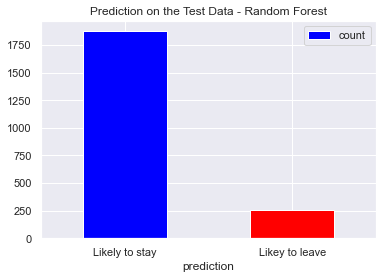

In [189]:
# Draw a vertical bar chart
dataFrame.plot.bar(x="prediction", y="count", rot=0, title="Prediction on the Test Data - Random Forest", color=("blue", "red"))
plt.show(block=True)

In [190]:
# logistic Regression 

In [191]:
hrds_test_y = model.predict(hrds_test_df)

In [192]:
data = {"prediction":np.unique(hrds_test_y),"count":np.unique(hrds_test_y,return_counts = True)[1]}
dataFrame = pd.DataFrame(data=data)
def categorize(x):
    if x == 0:
        return 'Likely to stay'
    else:
        return 'Likey to leave'
dataFrame.prediction = dataFrame.prediction.map(categorize)

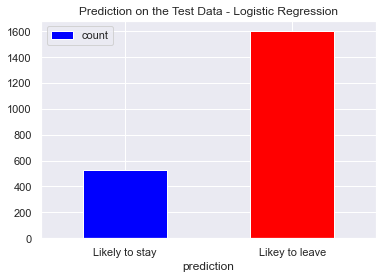

In [193]:
# Draw a vertical bar chart
dataFrame.plot.bar(x="prediction", y="count", rot=0, title="Prediction on the Test Data - Logistic Regression", color=("blue", "red"))
plt.show(block=True)

In [194]:
#KNN
hrds_test_y = pd.DataFrame(knn_model.predict(hrds_test_df))


In [195]:
data = {"prediction":np.unique(hrds_test_y),"count":np.unique(hrds_test_y,return_counts = True)[1]}
dataFrame = pd.DataFrame(data=data)
def categorize(x):
    if x == 0:
        return 'Likely to stay'
    else:
        return 'Likey to leave'
dataFrame.prediction = dataFrame.prediction.map(categorize)

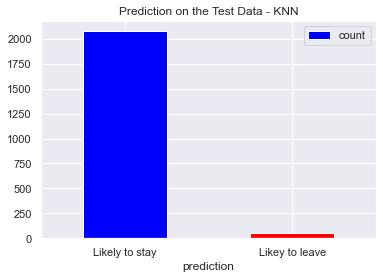

In [196]:
# Draw a vertical bar chart
dataFrame.plot.bar(x="prediction", y="count", rot=0, title="Prediction on the Test Data - KNN", color=("blue", "red"))
plt.show(block=True)